sigma = 0.010
sigma = 0.050
sigma = 0.100
sigma = 0.200
sigma = 0.300
sigma = 0.400
sigma = 0.500
sigma = 0.600
sigma = 0.700
sigma = 0.800
sigma = 0.900
sigma = 1.000

结果对比：
σ=0.010: MSE=0.1967
σ=0.050: MSE=0.1818
σ=0.100: MSE=0.1644
σ=0.200: MSE=0.1335
σ=0.300: MSE=0.1077
σ=0.400: MSE=0.0877
σ=0.500: MSE=0.0731
σ=0.600: MSE=0.0609
σ=0.700: MSE=0.0540
σ=0.800: MSE=0.0497
σ=0.900: MSE=0.0475
σ=1.000: MSE=0.0470

最优噪声强度: σ=1.000
最小MSE: 0.0470


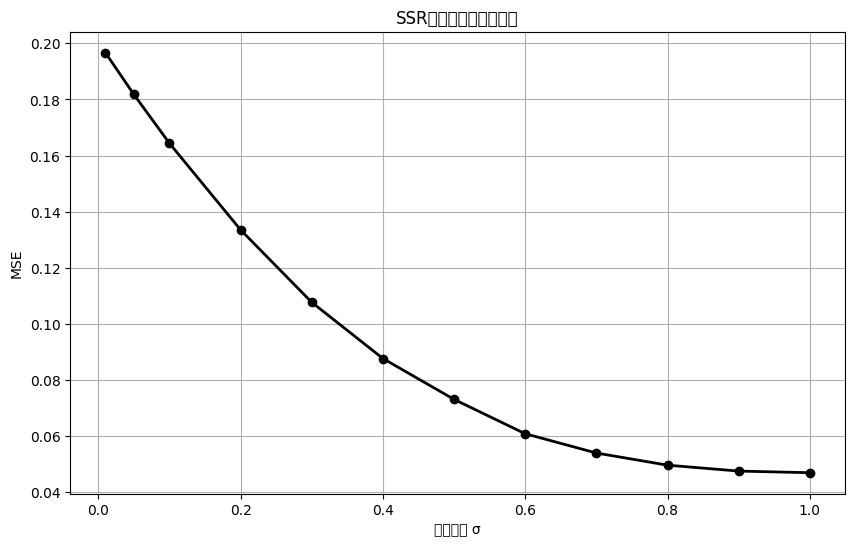

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def matlab_style_ssr(N, T, f=100, fs=1000, sigma_values=None):
    if sigma_values is None:
        sigma_values = [0.01, 0.05] + list(np.arange(0.1, 2.0, 0.1))
    
    ts = 1/fs
    t = np.arange(1, T+1)
    S_amp = np.sin(2*np.pi*f*ts*t)
    input1 = S_amp * np.random.randn(T)
    
    input_data = input1[np.random.permutation(T)]
    
    MSE_results = []
    thetas = np.zeros(N)
    
    for sigma in sigma_values:
        print(f'sigma = {sigma:.3f}')
        
        noise = sigma * np.random.randn(T, N)
        
        # sign 输出强制 ±1，避免 0
        yi = np.where(input_data.reshape(-1, 1) + noise - thetas.reshape(1, -1) >= 0, 1, -1)
        yi = yi.T  # (N, T)
        
        P = np.eye(N)
        w = np.ones(N)
        input_hat = np.zeros(T)
        
        for j in range(T):
            x = yi[:, j]
            Px = P @ x
            denom = x.T @ P @ x + 0.5
            g = Px / denom
            w = w + g * (input_data[j] - x.T @ w)
            P = P - np.outer(g, x.T @ P)
            input_hat[j] = x.T @ w
        
        mse = np.mean((input_data - input_hat)**2)
        MSE_results.append(mse)
    
    return sigma_values, MSE_results


# 测试
sigma_vals, mse_vals = matlab_style_ssr(N=63, T=10000)

print("\n结果对比：")
for sig, mse in zip(sigma_vals, mse_vals):
    print(f"σ={sig:.3f}: MSE={mse:.4f}")

min_idx = np.argmin(mse_vals)
print(f"\n最优噪声强度: σ={sigma_vals[min_idx]:.3f}")
print(f"最小MSE: {mse_vals[min_idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(sigma_vals, mse_vals, 'k-o', linewidth=2)
plt.xlabel('噪声强度 σ')
plt.ylabel('MSE')
plt.title('SSR性能曲线（修正版）')
plt.grid(True)
plt.show()


测试固定 sigma = 0.010
测试固定 sigma = 0.050
测试固定 sigma = 0.100
测试固定 sigma = 0.200
测试固定 sigma = 0.300
测试固定 sigma = 0.400
测试固定 sigma = 0.500
测试固定 sigma = 0.600
测试固定 sigma = 0.700
测试固定 sigma = 0.800
测试固定 sigma = 0.900
测试固定 sigma = 1.000
测试固定 sigma = 1.100
测试固定 sigma = 1.200
测试固定 sigma = 1.300
测试固定 sigma = 1.400
测试固定 sigma = 1.500
测试固定 sigma = 1.600
测试固定 sigma = 1.700
测试固定 sigma = 1.800
测试固定 sigma = 1.900
测试固定 sigma = 2.000

开始自适应过程... N=63, T=10000, sigma_0=0.5, alpha=0.0005
自适应过程结束。最终收敛的 sigma ≈ 1.0022


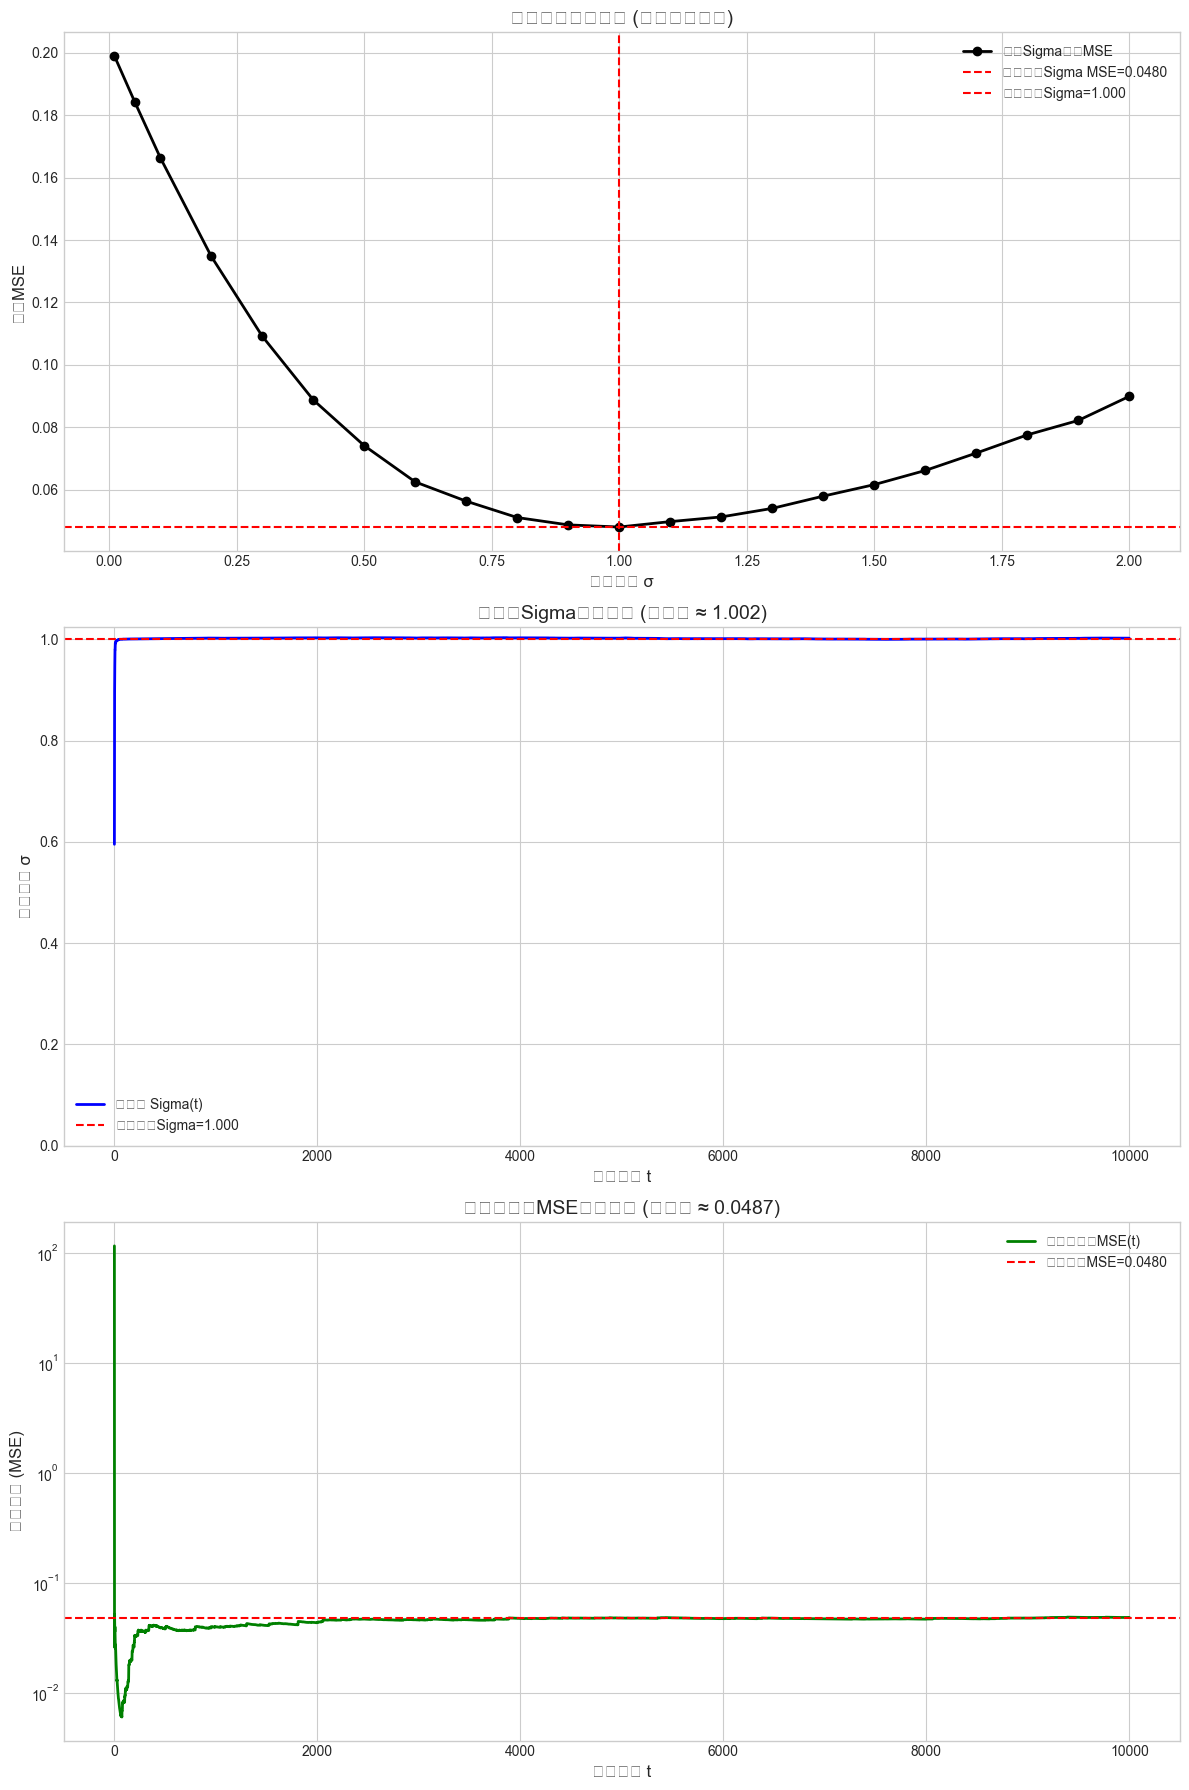

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore') # 忽略可能的数值计算警告

def matlab_style_ssr(N, T, f=100, fs=1000, sigma_values=None):
    """
    原始函数：遍历一个固定的sigma列表，为每个sigma计算最终的MSE。
    """
    if sigma_values is None:
        sigma_values = [0.01, 0.05] + list(np.arange(0.1, 2.1, 0.1))
    
    ts = 1/fs
    t = np.arange(1, T+1)
    S_amp = np.sin(2*np.pi*f*ts*t)
    input1 = S_amp * np.random.randn(T)
    input_data = input1[np.random.permutation(T)]
    
    MSE_results = []
    thetas = np.zeros(N)
    
    for sigma in sigma_values:
        print(f'测试固定 sigma = {sigma:.3f}')
        
        noise = sigma * np.random.randn(T, N)
        
        # sign 输出强制 ±1，避免 0
        yi = np.where(input_data.reshape(-1, 1) + noise - thetas.reshape(1, -1) >= 0, 1, -1)
        yi = yi.T  # (N, T)
        
        P = np.eye(N)
        w = np.ones(N)
        input_hat = np.zeros(T)
        
        for j in range(T):
            x = yi[:, j]
            # Kalman-LMS 权重更新
            Px = P @ x
            denom = x.T @ P @ x + 0.5
            g = Px / denom
            w = w + g * (input_data[j] - x.T @ w)
            P = P - np.outer(g, x.T @ P)
            input_hat[j] = x.T @ w
        
        mse = np.mean((input_data - input_hat)**2)
        MSE_results.append(mse)
    
    return sigma_values, MSE_results, input_data

def adaptive_ssr(N, T, f=100, fs=1000, input_data=None, sigma_0=0.8, alpha=5e-5):
    """
    新函数：Sigma参数在此函数内部自适应调整。
    
    参数:
    sigma_0: 噪声强度的初始值
    alpha: 噪声强度更新的学习率 (这是一个关键参数，需要小心调整)
    """
    if input_data is None:
        ts = 1/fs
        t = np.arange(1, T+1)
        S_amp = np.sin(2*np.pi*f*ts*t)
        input1 = S_amp * np.random.randn(T)
        input_data = input1[np.random.permutation(T)]

    thetas = np.zeros(N)
    
    # 初始化
    P = np.eye(N)
    w = np.ones(N)
    sigma = sigma_0
    
    # 用于记录历史数据
    input_hat = np.zeros(T)
    sigma_history = np.zeros(T)
    mse_history = np.zeros(T)

    print(f"\n开始自适应过程... N={N}, T={T}, sigma_0={sigma_0}, alpha={alpha}")

    for j in range(T):
        # 1. 使用当前的sigma生成该时刻的噪声
        noise_j = sigma * np.random.randn(N)
        
        # 2. 计算系统输出
        y_j = np.where(input_data[j] + noise_j - thetas >= 0, 1, -1)
        
        # 3. 计算误差 (使用更新前的权重)
        error = input_data[j] - y_j.T @ w
        
        # 4. 更新权重 w (Kalman-LMS)
        Px = P @ y_j
        denom = y_j.T @ P @ y_j + 0.5
        g = Px / denom
        w = w + g * error
        P = P - np.outer(g, y_j.T @ P)
        
        # 5. 更新噪声强度 sigma (SGD)
        # 梯度项的推导: d(E[y_i])/d(sigma) 正比于 phi((theta_i-x_k)/sigma) * (theta_i-x_k)/sigma^2
        # 在这里 theta_i = 0, x_k = input_data[j]
        # 由于是+/-1输出, 梯度推导中会有一个常数2, 我们将其吸收到alpha中
        x_k = input_data[j]
        
        # 避免 sigma 过小导致数值不稳定
        if sigma < 1e-4:
            sigma = 1e-4
            
        grad_term_multiplier = norm.pdf(-x_k / sigma) * (-x_k / (sigma**2))
        grad_sum = np.sum(w * grad_term_multiplier) # 使用更新后的 w 来计算梯度
        
        # SGD 更新 sigma
        sigma = sigma + alpha * error * grad_sum
        
        # 6. 确保 sigma 为正
        sigma = max(sigma, 1e-6)
        
        # 7. 记录数据
        input_hat[j] = y_j.T @ w
        sigma_history[j] = sigma
        mse_history[j] = np.mean((input_data[:j+1] - input_hat[:j+1])**2) if j > 0 else error**2

    print(f"自适应过程结束。最终收敛的 sigma ≈ {sigma:.4f}")
    return sigma_history, mse_history, input_data, input_hat

# --- 参数设置 ---
N = 63
T = 10000

# --- 运行原始算法以找到“最优”sigma作为参考 ---
sigma_vals, mse_vals, input_data_for_test = matlab_style_ssr(N=N, T=T)
min_idx = np.argmin(mse_vals)
optimal_sigma_ref = sigma_vals[min_idx]
min_mse_ref = mse_vals[min_idx]

# --- 运行新的自适应算法 ---
# 使用相同的输入数据以保证公平比较
# alpha需要仔细调整, 如果sigma发散或收敛过慢, 尝试改变alpha (通常在1e-4到1e-7之间)
sigma_hist, mse_hist, _, _ = adaptive_ssr(
    N=N, 
    T=T, 
    input_data=input_data_for_test, 
    sigma_0=0.5,  # 从一个非最优值开始
    alpha=5e-4
)


# --- 结果可视化 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 1. 绘制原始SSR性能曲线
axs[0].plot(sigma_vals, mse_vals, 'k-o', linewidth=2, label='固定Sigma下的MSE')
axs[0].axhline(y=min_mse_ref, color='r', linestyle='--', label=f'最优固定Sigma MSE={min_mse_ref:.4f}')
axs[0].axvline(x=optimal_sigma_ref, color='r', linestyle='--', label=f'最优固定Sigma={optimal_sigma_ref:.3f}')
axs[0].set_title('原始算法性能曲线 (作为参考基准)', fontsize=14)
axs[0].set_xlabel('噪声强度 σ', fontsize=12)
axs[0].set_ylabel('最终MSE', fontsize=12)
axs[0].legend()

# 2. 绘制自适应Sigma的收敛过程
axs[1].plot(sigma_hist, color='blue', linewidth=2, label='自适应 Sigma(t)')
axs[1].axhline(y=optimal_sigma_ref, color='r', linestyle='--', label=f'参考最优Sigma={optimal_sigma_ref:.3f}')
axs[1].set_title(f'自适应Sigma收敛过程 (最终值 ≈ {sigma_hist[-1]:.3f})', fontsize=14)
axs[1].set_xlabel('迭代次数 t', fontsize=12)
axs[1].set_ylabel('噪声强度 σ', fontsize=12)
axs[1].legend()
axs[1].set_ylim(bottom=0)

# 3. 绘制自适应过程中的MSE变化
axs[2].plot(mse_hist, color='green', linewidth=2, label='自适应过程MSE(t)')
axs[2].axhline(y=min_mse_ref, color='r', linestyle='--', label=f'参考最小MSE={min_mse_ref:.4f}')
axs[2].set_title(f'自适应过程MSE收敛曲线 (最终值 ≈ {mse_hist[-1]:.4f})', fontsize=14)
axs[2].set_xlabel('迭代次数 t', fontsize=12)
axs[2].set_ylabel('均方误差 (MSE)', fontsize=12)
axs[2].set_yscale('log') # 使用对数坐标以便观察初始阶段的变化
axs[2].legend()


plt.tight_layout()
plt.show()

=== 运行原始固定sigma算法 ===
测试固定 sigma = 0.010
测试固定 sigma = 0.050
测试固定 sigma = 0.100
测试固定 sigma = 0.200
测试固定 sigma = 0.300
测试固定 sigma = 0.400
测试固定 sigma = 0.500
测试固定 sigma = 0.600
测试固定 sigma = 0.700
测试固定 sigma = 0.800
测试固定 sigma = 0.900
测试固定 sigma = 1.000
测试固定 sigma = 1.100
测试固定 sigma = 1.200
测试固定 sigma = 1.300
测试固定 sigma = 1.400
测试固定 sigma = 1.500
测试固定 sigma = 1.600
测试固定 sigma = 1.700
测试固定 sigma = 1.800
测试固定 sigma = 1.900
测试固定 sigma = 2.000
参考最优sigma: 1.100, MSE: 0.045216

=== 开始多臂赌博机超参数搜索 ===

测试参数组合 1: {'method': 'momentum', 'alpha': 0.0001, 'momentum': 0.9}
使用动量法: alpha=0.0001, momentum=0.9
开始自适应过程... N=63, T=3000, sigma_0=0.5
自适应过程结束。最终收敛的 sigma ≈ 1.2174
使用动量法: alpha=0.0001, momentum=0.9
开始自适应过程... N=63, T=3000, sigma_0=0.5
自适应过程结束。最终收敛的 sigma ≈ 1.3889
平均最终MSE: 0.051668

测试参数组合 2: {'method': 'adam', 'alpha': 0.001, 'beta1': 0.9, 'beta2': 0.999}
使用Adam优化器: alpha=0.001, beta1=0.9, beta2=0.999
开始自适应过程... N=63, T=3000, sigma_0=0.5
自适应过程结束。最终收敛的 sigma ≈ 0.5226
使用Adam优化器: alpha=0.001, beta1=0

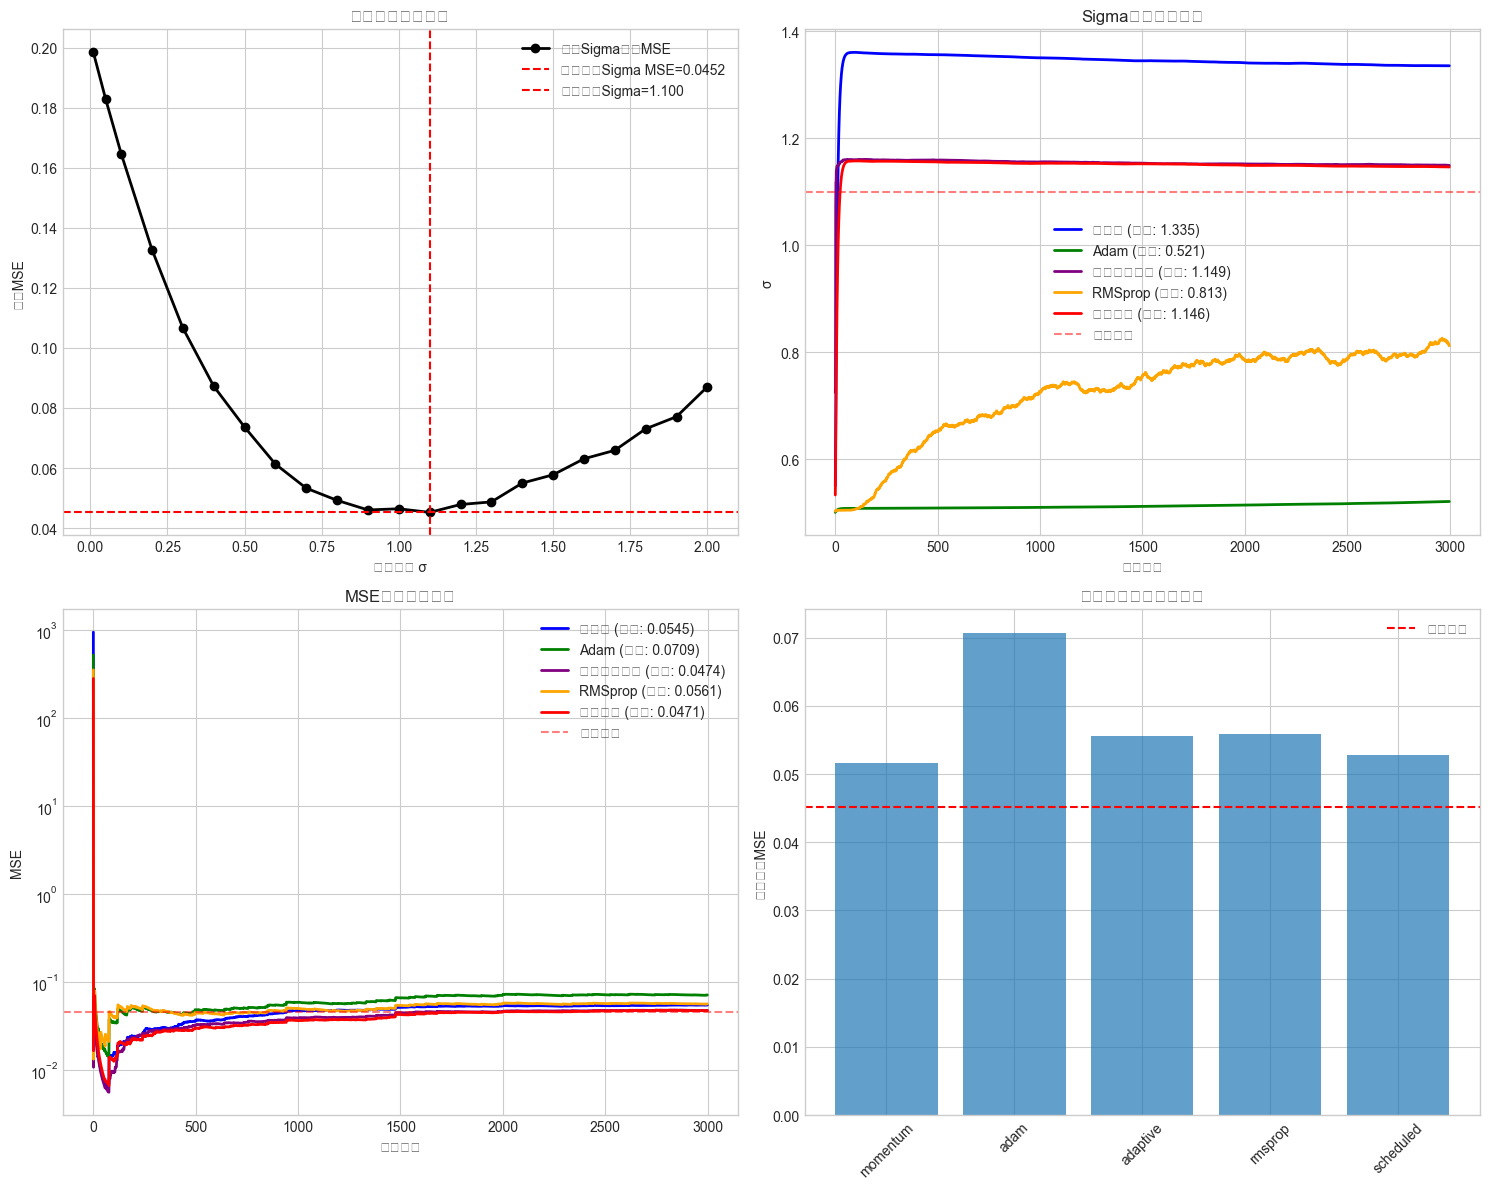


=== 最终总结 ===
参考固定最优sigma: 1.100, MSE: 0.045216
最佳自适应方法: momentum, 最终MSE: 0.047142
相对于固定最优的性能比: 1.04


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

def matlab_style_ssr(N, T, f=100, fs=1000, sigma_values=None):
    """
    原始函数：遍历一个固定的sigma列表，为每个sigma计算最终的MSE。
    """
    if sigma_values is None:
        sigma_values = [0.01, 0.05] + list(np.arange(0.1, 2.1, 0.1))
    
    ts = 1/fs
    t = np.arange(1, T+1)
    S_amp = np.sin(2*np.pi*f*ts*t)
    input1 = S_amp * np.random.randn(T)
    input_data = input1[np.random.permutation(T)]
    
    MSE_results = []
    thetas = np.zeros(N)
    
    for sigma in sigma_values:
        print(f'测试固定 sigma = {sigma:.3f}')
        
        noise = sigma * np.random.randn(T, N)
        
        # sign 输出强制 ±1，避免 0
        yi = np.where(input_data.reshape(-1, 1) + noise - thetas.reshape(1, -1) >= 0, 1, -1)
        yi = yi.T  # (N, T)
        
        P = np.eye(N)
        w = np.ones(N)
        input_hat = np.zeros(T)
        
        for j in range(T):
            x = yi[:, j]
            # Kalman-LMS 权重更新
            Px = P @ x
            denom = x.T @ P @ x + 0.5
            g = Px / denom
            w = w + g * (input_data[j] - x.T @ w)
            P = P - np.outer(g, x.T @ P)
            input_hat[j] = x.T @ w
        
        mse = np.mean((input_data - input_hat)**2)
        MSE_results.append(mse)
    
    return sigma_values, MSE_results, input_data

def adaptive_ssr_improved(N, T, f=100, fs=1000, input_data=None, sigma_0=0.8, 
                         method='momentum', **kwargs):
    """
    改进的自适应SSR算法，支持多种学习率优化策略
    
    Parameters:
    method: 选择优化方法
        - 'momentum': 动量法
        - 'adam': Adam优化器
        - 'adaptive': 自适应学习率
        - 'rmsprop': RMSprop
        - 'scheduled': 学习率调度
    """
    if input_data is None:
        ts = 1/fs
        t = np.arange(1, T+1)
        S_amp = np.sin(2*np.pi*f*ts*t)
        input1 = S_amp * np.random.randn(T)
        input_data = input1[np.random.permutation(T)]
    elif len(input_data) < T:
        # 如果输入数据长度不够，生成新的数据或循环使用现有数据
        print(f"警告：输入数据长度({len(input_data)})小于所需长度({T})，将循环使用现有数据")
        input_data = np.tile(input_data, (T // len(input_data) + 1))[:T]

    thetas = np.zeros(N)
    
    # 初始化
    P = np.eye(N)
    w = np.ones(N)
    sigma = sigma_0
    
    # 用于记录历史数据
    input_hat = np.zeros(T)
    sigma_history = np.zeros(T)
    mse_history = np.zeros(T)
    
    # 不同方法的特定参数初始化
    if method == 'momentum':
        alpha = kwargs.get('alpha', 1e-4)
        momentum = kwargs.get('momentum', 0.9)
        velocity = 0.0
        print(f"使用动量法: alpha={alpha}, momentum={momentum}")
        
    elif method == 'adam':
        alpha = kwargs.get('alpha', 1e-3)
        beta1 = kwargs.get('beta1', 0.9)
        beta2 = kwargs.get('beta2', 0.999)
        epsilon = kwargs.get('epsilon', 1e-8)
        m = 0.0  # 一阶动量
        v = 0.0  # 二阶动量
        print(f"使用Adam优化器: alpha={alpha}, beta1={beta1}, beta2={beta2}")
        
    elif method == 'adaptive':
        alpha_init = kwargs.get('alpha_init', 1e-3)
        alpha_decay = kwargs.get('alpha_decay', 0.995)
        alpha_min = kwargs.get('alpha_min', 1e-6)
        alpha = alpha_init
        print(f"使用自适应学习率: alpha_init={alpha_init}, decay={alpha_decay}")
        
    elif method == 'rmsprop':
        alpha = kwargs.get('alpha', 1e-3)
        decay_rate = kwargs.get('decay_rate', 0.9)
        epsilon = kwargs.get('epsilon', 1e-8)
        cache = 0.0
        print(f"使用RMSprop: alpha={alpha}, decay_rate={decay_rate}")
        
    elif method == 'scheduled':
        alpha_init = kwargs.get('alpha_init', 1e-3)
        schedule_type = kwargs.get('schedule_type', 'exponential')  # 'exponential', 'step', 'cosine'
        print(f"使用学习率调度: {schedule_type}")
        
    else:
        # 默认使用简单的固定学习率
        alpha = kwargs.get('alpha', 5e-5)
        print(f"使用固定学习率: alpha={alpha}")

    print(f"开始自适应过程... N={N}, T={T}, sigma_0={sigma_0}")

    for j in range(T):
        # 1. 使用当前的sigma生成该时刻的噪声
        noise_j = sigma * np.random.randn(N)
        
        # 2. 计算系统输出 - 确保索引在有效范围内
        if j < len(input_data):
            current_input = input_data[j]
        else:
            # 如果索引超出范围，使用循环索引
            current_input = input_data[j % len(input_data)]
            
        y_j = np.where(current_input + noise_j - thetas >= 0, 1, -1)
        
        # 3. 计算误差
        error = current_input - y_j.T @ w
        
        # 4. 更新权重 w (Kalman-LMS)
        Px = P @ y_j
        denom = y_j.T @ P @ y_j + 0.5
        g = Px / denom
        w = w + g * error
        P = P - np.outer(g, y_j.T @ P)
        
        # 5. 计算梯度
        x_k = current_input
        if sigma < 1e-6:
            sigma = 1e-6
            
        grad_term_multiplier = norm.pdf(-x_k / sigma) * (-x_k / (sigma**2))
        grad_sigma = error * np.sum(w * grad_term_multiplier)
        
        # 6. 根据选择的方法更新sigma
        if method == 'momentum':
            velocity = momentum * velocity + alpha * grad_sigma
            sigma = sigma + velocity
            
        elif method == 'adam':
            # Adam优化器
            m = beta1 * m + (1 - beta1) * grad_sigma
            v = beta2 * v + (1 - beta2) * (grad_sigma ** 2)
            
            # 偏差修正
            m_hat = m / (1 - beta1 ** (j + 1))
            v_hat = v / (1 - beta2 ** (j + 1))
            
            sigma = sigma + alpha * m_hat / (np.sqrt(v_hat) + epsilon)
            
        elif method == 'adaptive':
            # 自适应学习率：根据梯度大小调整
            if j > 10:  # 等待一些迭代后开始调整
                recent_grad_std = np.std([grad_sigma])  # 可以维护一个窗口
                if recent_grad_std > 1.0:  # 梯度较大时减小学习率
                    alpha = max(alpha * alpha_decay, alpha_min)
            sigma = sigma + alpha * grad_sigma
            
        elif method == 'rmsprop':
            # RMSprop
            cache = decay_rate * cache + (1 - decay_rate) * (grad_sigma ** 2)
            sigma = sigma + alpha * grad_sigma / (np.sqrt(cache) + epsilon)
            
        elif method == 'scheduled':
            # 学习率调度
            if schedule_type == 'exponential':
                current_alpha = alpha_init * (0.95 ** (j // 1000))
            elif schedule_type == 'step':
                current_alpha = alpha_init * (0.5 ** (j // 2000))
            elif schedule_type == 'cosine':
                current_alpha = alpha_init * (1 + np.cos(np.pi * j / T)) / 2
            else:
                current_alpha = alpha_init
                
            sigma = sigma + current_alpha * grad_sigma
            
        else:
            # 默认固定学习率
            sigma = sigma + alpha * grad_sigma
        
        # 7. 确保 sigma 为正，并添加合理的边界
        sigma = np.clip(sigma, 1e-6, 5.0)  # 限制sigma的范围
        
        # 8. 记录数据
        input_hat[j] = y_j.T @ w
        sigma_history[j] = sigma
        
        # 计算累积MSE时也要处理索引问题
        actual_length = min(j+1, len(input_data))
        mse_history[j] = np.mean((input_data[:actual_length] - input_hat[:actual_length])**2) if j > 0 else error**2

    print(f"自适应过程结束。最终收敛的 sigma ≈ {sigma:.4f}")
    return sigma_history, mse_history, input_data, input_hat

# 多臂赌博机式的超参数搜索
def bandit_hyperparameter_search(N, T, input_data, n_arms=5, n_trials=2):
    """
    使用多臂赌博机思想搜索最优超参数组合
    """
    print("\n=== 开始多臂赌博机超参数搜索 ===")
    
    # 定义候选超参数组合
    param_arms = [
        {'method': 'momentum', 'alpha': 1e-4, 'momentum': 0.9},
        {'method': 'adam', 'alpha': 1e-3, 'beta1': 0.9, 'beta2': 0.999},
        {'method': 'adaptive', 'alpha_init': 1e-3, 'alpha_decay': 0.995},
        {'method': 'rmsprop', 'alpha': 1e-3, 'decay_rate': 0.9},
        {'method': 'scheduled', 'alpha_init': 1e-3, 'schedule_type': 'exponential'}
    ]
    
    arm_rewards = []
    best_reward = float('inf')
    best_params = None
    
    for i, params in enumerate(param_arms):
        print(f"\n测试参数组合 {i+1}: {params}")
        
        # 运行多次试验取平均
        trial_rewards = []
        for trial in range(n_trials):
            _, mse_hist, _, _ = adaptive_ssr_improved(
                N=N, T=T, input_data=input_data, 
                sigma_0=0.5, **params
            )
            final_mse = mse_hist[-1]
            trial_rewards.append(final_mse)
        
        avg_reward = np.mean(trial_rewards)
        arm_rewards.append(avg_reward)
        
        print(f"平均最终MSE: {avg_reward:.6f}")
        
        if avg_reward < best_reward:
            best_reward = avg_reward
            best_params = params.copy()
    
    print(f"\n最佳参数组合: {best_params}")
    print(f"最佳性能: MSE = {best_reward:.6f}")
    
    return best_params, arm_rewards

# --- 主程序 ---
if __name__ == "__main__":
    # 参数设置
    N = 63
    T = 3000  # 减少T以加快超参数搜索，避免数据长度问题
    
    # 运行原始算法作为基准
    print("=== 运行原始固定sigma算法 ===")
    sigma_vals, mse_vals, input_data_for_test = matlab_style_ssr(N=N, T=T)
    min_idx = np.argmin(mse_vals)
    optimal_sigma_ref = sigma_vals[min_idx]
    min_mse_ref = mse_vals[min_idx]
    
    print(f"参考最优sigma: {optimal_sigma_ref:.3f}, MSE: {min_mse_ref:.6f}")
    
    # 超参数搜索
    best_params, arm_rewards = bandit_hyperparameter_search(N, T, input_data_for_test)
    
    # 使用最佳参数运行完整测试
    print(f"\n=== 使用最佳参数运行完整测试 (T={T}) ===")
    
    sigma_hist_best, mse_hist_best, _, _ = adaptive_ssr_improved(
        N=N, T=T, input_data=input_data_for_test,
        sigma_0=0.5, **best_params
    )
    
    # 比较所有方法
    print(f"\n=== 运行所有方法的比较 ===")
    methods_to_compare = [
        ('动量法', {'method': 'momentum', 'alpha': 1e-4, 'momentum': 0.9}),
        ('Adam', {'method': 'adam', 'alpha': 1e-3}),
        ('自适应学习率', {'method': 'adaptive', 'alpha_init': 1e-3}),
        ('RMSprop', {'method': 'rmsprop', 'alpha': 1e-3}),
        ('最佳参数', best_params)
    ]
    
    results = {}
    for name, params in methods_to_compare:
        print(f"\n测试 {name}...")
        sigma_hist, mse_hist, _, _ = adaptive_ssr_improved(
            N=N, T=T, input_data=input_data_for_test, 
            sigma_0=0.5, **params
        )
        results[name] = {
            'sigma_hist': sigma_hist,
            'mse_hist': mse_hist,
            'final_mse': mse_hist[-1],
            'final_sigma': sigma_hist[-1]
        }
        print(f"{name}: 最终MSE = {mse_hist[-1]:.6f}, 最终sigma = {sigma_hist[-1]:.4f}")
    
    # 可视化结果
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 原始SSR性能曲线
    axs[0,0].plot(sigma_vals, mse_vals, 'k-o', linewidth=2, label='固定Sigma下的MSE')
    axs[0,0].axhline(y=min_mse_ref, color='r', linestyle='--', label=f'最优固定Sigma MSE={min_mse_ref:.4f}')
    axs[0,0].axvline(x=optimal_sigma_ref, color='r', linestyle='--', label=f'最优固定Sigma={optimal_sigma_ref:.3f}')
    axs[0,0].set_title('原始算法性能曲线', fontsize=12)
    axs[0,0].set_xlabel('噪声强度 σ')
    axs[0,0].set_ylabel('最终MSE')
    axs[0,0].legend()
    
    # 2. Sigma收敛过程比较
    colors = ['blue', 'green', 'purple', 'orange', 'red']
    for i, (name, result) in enumerate(results.items()):
        axs[0,1].plot(result['sigma_hist'], color=colors[i % len(colors)], 
                     linewidth=2, label=f'{name} (最终: {result["final_sigma"]:.3f})')
    axs[0,1].axhline(y=optimal_sigma_ref, color='r', linestyle='--', alpha=0.5, label='参考最优')
    axs[0,1].set_title('Sigma收敛过程比较')
    axs[0,1].set_xlabel('迭代次数')
    axs[0,1].set_ylabel('σ')
    axs[0,1].legend()
    
    # 3. MSE收敛过程比较
    for i, (name, result) in enumerate(results.items()):
        axs[1,0].plot(result['mse_hist'], color=colors[i % len(colors)], 
                     linewidth=2, label=f'{name} (最终: {result["final_mse"]:.4f})')
    axs[1,0].axhline(y=min_mse_ref, color='r', linestyle='--', alpha=0.5, label='参考最优')
    axs[1,0].set_title('MSE收敛过程比较')
    axs[1,0].set_xlabel('迭代次数')
    axs[1,0].set_ylabel('MSE')
    axs[1,0].set_yscale('log')
    axs[1,0].legend()
    
    # 4. 超参数搜索结果
    method_names = [params['method'] for params in [
        {'method': 'momentum'}, {'method': 'adam'}, {'method': 'adaptive'},
        {'method': 'rmsprop'}, {'method': 'scheduled'}
    ]]
    axs[1,1].bar(method_names, arm_rewards, alpha=0.7)
    axs[1,1].axhline(y=min_mse_ref, color='r', linestyle='--', label='参考最优')
    axs[1,1].set_title('不同优化方法性能比较')
    axs[1,1].set_ylabel('平均最终MSE')
    axs[1,1].tick_params(axis='x', rotation=45)
    axs[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== 最终总结 ===")
    print(f"参考固定最优sigma: {optimal_sigma_ref:.3f}, MSE: {min_mse_ref:.6f}")
    print(f"最佳自适应方法: {best_params['method']}, 最终MSE: {results[list(results.keys())[-1]]['final_mse']:.6f}")
    print(f"相对于固定最优的性能比: {results[list(results.keys())[-1]]['final_mse']/min_mse_ref:.2f}")